<a href="https://colab.research.google.com/github/kunalpagarey/PyTocrh_Tutorial/blob/master/PyTorch_Transfer_Learning_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [0]:
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                transforms.ColorJitter(brightness=1, saturation=1, contrast=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('ants_and_bees/train/', transform=train_transform)
val_data = datasets.ImageFolder('ants_and_bees/val/', transform=transform)

train_loader = DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = DataLoader(val_data, batch_size=20)

def convert_image(img):
    image = img.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image


In [5]:
classes = ('ant', 'bee')

print(len(train_loader.dataset))
print(len(val_loader.dataset))

244
153


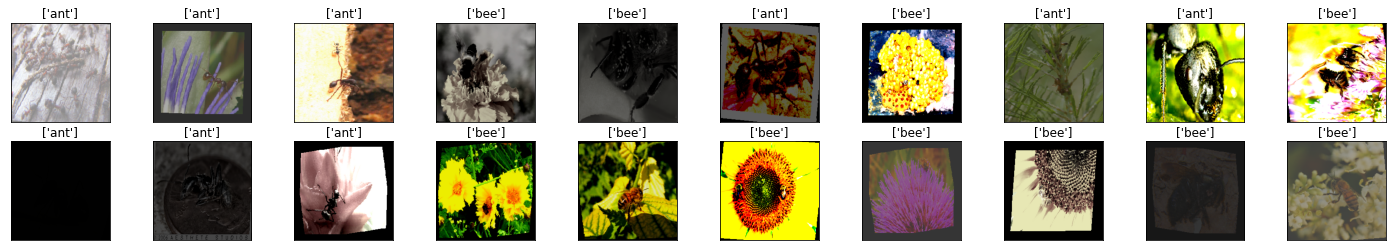

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(convert_image(images[idx]))
    ax.set_title([classes[labels[idx].item()]])

In [7]:
# Load AlexNet
alexnet_model = models.alexnet(pretrained=True)
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for param in alexnet_model.features.parameters():
    param.requires_grad = False

In [9]:
n_in = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(n_in, len(classes))
alexnet_model.to(device)
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
model = alexnet_model

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [12]:
epochs = 10
t_losses = []
t_accuracy = []
v_losses = []
v_accuracy = []
for e in range(epochs):
    te_loss = 0.0
    te_correct = 0.0
    ve_loss = 0.0
    ve_correct = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)

        te_loss += loss.item()
        te_correct += torch.sum(pred == labels)

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, pred = torch.max(outputs, 1)

            ve_loss += loss.item()
            ve_correct += torch.sum(pred == labels)
    
    te_loss = te_loss/len(train_loader.dataset)
    te_correct = te_correct/len(train_loader.dataset)
    ve_loss = ve_loss/len(val_loader.dataset)
    ve_correct = ve_correct/len(val_loader.dataset)

    t_losses.append(te_loss)
    t_accuracy.append(te_correct)
    v_losses.append(ve_loss)
    v_accuracy.append(ve_correct)
    print("Epoch: {}, Train: Loss={:0.4f}, Accuracy={:0.4f}, Val: Loss={:0.4f}"\
          ", Accuracy={:0.4f}".format(e, te_loss, te_correct.item(), ve_loss,
                                      ve_correct.item()))

Epoch: 0, Train: Loss=0.0335, Accuracy=0.6475, Val: Loss=0.0189, Accuracy=0.8562
Epoch: 1, Train: Loss=0.0295, Accuracy=0.7377, Val: Loss=0.0186, Accuracy=0.8758
Epoch: 2, Train: Loss=0.0233, Accuracy=0.7869, Val: Loss=0.0166, Accuracy=0.8954
Epoch: 3, Train: Loss=0.0215, Accuracy=0.7664, Val: Loss=0.0175, Accuracy=0.8562
Epoch: 4, Train: Loss=0.0195, Accuracy=0.8279, Val: Loss=0.0198, Accuracy=0.8824
Epoch: 5, Train: Loss=0.0188, Accuracy=0.8115, Val: Loss=0.0234, Accuracy=0.8627
Epoch: 6, Train: Loss=0.0195, Accuracy=0.8033, Val: Loss=0.0176, Accuracy=0.9020
Epoch: 7, Train: Loss=0.0190, Accuracy=0.8361, Val: Loss=0.0183, Accuracy=0.9150
Epoch: 8, Train: Loss=0.0198, Accuracy=0.7869, Val: Loss=0.0173, Accuracy=0.9020
Epoch: 9, Train: Loss=0.0161, Accuracy=0.8525, Val: Loss=0.0173, Accuracy=0.9085


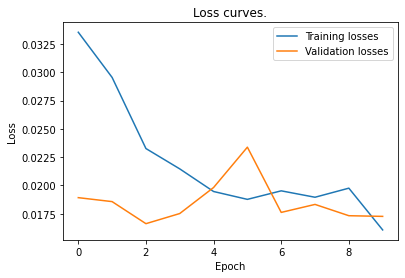

In [13]:
plt.plot(t_losses, label="Training losses")
plt.plot(v_losses, label="Validation losses")
plt.title("Loss curves.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

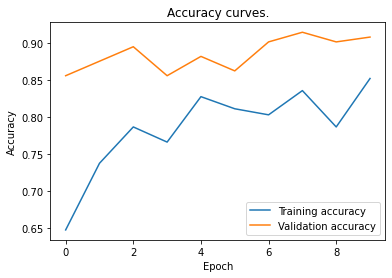

In [14]:
plt.plot(t_accuracy, label="Training accuracy")
plt.plot(v_accuracy, label="Validation accuracy")
plt.title("Accuracy curves.")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [0]:
import PIL.ImageOps as ops
from PIL import Image
import requests

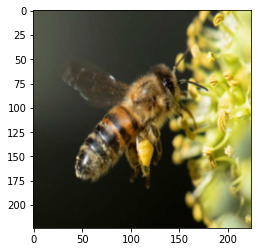

In [16]:
# url = 'http://cdn.sci-news.com/images/enlarge5/image_6425e-Giant-Red-Bull-Ant.jpg'
url = 'https://img.etimg.com/thumb/width-640,height-480,imgsize-47014,resizemode-1,msid-68370560/honey-bees-may-tell-how-clean-your-city-is-study.jpg'

response = requests.get(url, stream=True)
img = Image.open(response.raw)
img = transform(img)
plt.imshow(convert_image(img))

In [17]:
im = img.to(device)
im = im.unsqueeze(0)
out = model(im)
_, prediction = torch.max(out, 1)
print(classes[prediction.item()])

bee


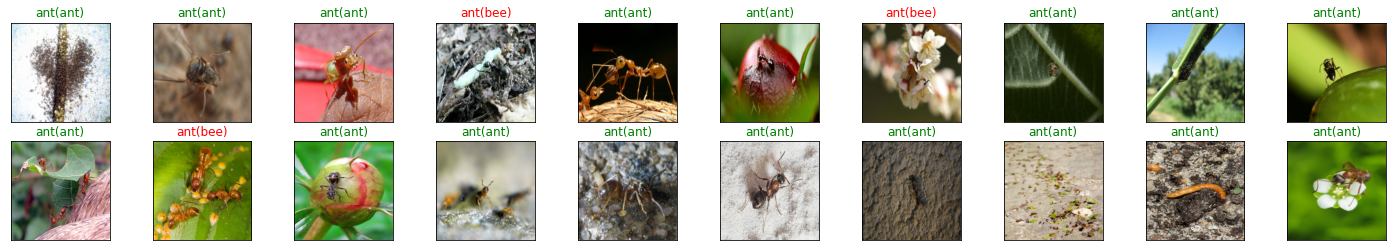

In [18]:
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
logits = model(images)
_, predictions = torch.max(logits, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(convert_image(images[idx]))
    ax.set_title("{}({})".format(str(classes[labels[idx].item()]), str(classes[predictions[idx].item()])), 
                 color="green" if predictions[idx] == labels[idx] else "red")